In [1]:
import os
from glob import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

In [9]:
from pkg.kitti_utils import *
from ultralytics import YOLO


In [3]:
DATA_PATH = r'./../visionNav/fusion/dataset/2011_10_03_drive_0047_sync'

# get RGB camera data
left_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_02/data/*.png')))
right_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_03/data/*.png')))

# get LiDAR data
bin_paths = sorted(glob(os.path.join(DATA_PATH, 'velodyne_points/data/*.bin')))

# get GPS/IMU data
oxts_paths = sorted(glob(os.path.join(DATA_PATH, r'oxts/data**/*.txt')))

print(f"Number of left images: {len(left_image_paths)}")
print(f"Number of right images: {len(right_image_paths)}")
print(f"Number of LiDAR point clouds: {len(bin_paths)}")
print(f"Number of GPS/IMU frames: {len(oxts_paths)}")

Number of left images: 837
Number of right images: 837
Number of LiDAR point clouds: 837
Number of GPS/IMU frames: 837


In [4]:
with open('./../visionNav/fusion/dataset/2011_10_03_calib/calib_cam_to_cam.txt','r') as f:
    calib = f.readlines()

# get projection matrices (rectified left camera --> left camera (u,v,z))
P_rect2_cam2 = np.array([float(x) for x in calib[25].strip().split(' ')[1:]]).reshape((3,4))


# get rectified rotation matrices (left camera --> rectified left camera)
R_ref0_rect2 = np.array([float(x) for x in calib[24].strip().split(' ')[1:]]).reshape((3, 3,))

# add (0,0,0) translation and convert to homogeneous coordinates
R_ref0_rect2 = np.insert(R_ref0_rect2, 3, values=[0,0,0], axis=0)
R_ref0_rect2 = np.insert(R_ref0_rect2, 3, values=[0,0,0,1], axis=1)


# get rigid transformation from Camera 0 (ref) to Camera 2
R_2 = np.array([float(x) for x in calib[21].strip().split(' ')[1:]]).reshape((3,3))
t_2 = np.array([float(x) for x in calib[22].strip().split(' ')[1:]]).reshape((3,1))

# get cam0 to cam2 rigid body transformation in homogeneous coordinates
T_ref0_ref2 = np.insert(np.hstack((R_2, t_2)), 3, values=[0,0,0,1], axis=0)

## **Load LiDAR and GPS/IMU Calibration Data**

In [6]:
T_velo_ref0 = get_rigid_transformation(r'./../visionNav/fusion/dataset/2011_10_03_calib/calib_velo_to_cam.txt')
T_imu_velo = get_rigid_transformation(r'./../visionNav/fusion/dataset/2011_10_03_calib/calib_imu_to_velo.txt')

In [7]:
# transform from velo (LiDAR) to left color camera (shape 3x4)
T_velo_cam2 = P_rect2_cam2 @ R_ref0_rect2 @ T_ref0_ref2 @ T_velo_ref0 

# homogeneous transform from left color camera to velo (LiDAR) (shape: 4x4)
T_cam2_velo = np.linalg.inv(np.insert(T_velo_cam2, 3, values=[0,0,0,1], axis=0)) 

In [8]:
# transform from IMU to left color camera (shape 3x4)
T_imu_cam2 = T_velo_cam2 @ T_imu_velo

# homogeneous transform from left color camera to IMU (shape: 4x4)
T_cam2_imu = np.linalg.inv(np.insert(T_imu_cam2, 3, values=[0,0,0,1], axis=0)) 

In [22]:
model = YOLO("yolov8s.pt")
model.conf = 0.8  # confidence threshold
model.iou = 0.5 # NMS IoU threshold
model.classes = [0, 1, 2, 3, 5, 7]  # only person, bicycle, car, motorcycle, bus, truck

In [28]:
def get_uvz_centers(image, velo_uvz, bboxes, draw=True):
    ''' Obtains detected object centers projected to uvz camera coordinates. 
        Starts by associating LiDAR uvz coordinates to detected object centers,
        once a match is found, the coordiantes are transformed to the uvz
        camera reference and added to the bboxes array.

        NOTE: The image is modified in place so there is no need to return it.

        Inputs:
          image - input image for detection 
          velo_uvz - LiDAR coordinates projected to camera reference
          bboxes - xyxy bounding boxes form detections from yolov5 model output
          draw - (_Bool) draw measured depths on image
        Outputs:
          bboxes_out - modified array containing the object centers projected
                       to uvz image coordinates
        '''

    # unpack LiDAR camera coordinates
    u, v, z = velo_uvz

    # get new output
    bboxes_out = np.zeros((bboxes.shape[0], bboxes.shape[1] + 3))
    bboxes_out[:, :bboxes.shape[1]] = bboxes

    # iterate through all detected bounding boxes
    for i, bbox in enumerate(bboxes):
        pt1 = np.round(bbox[0:2]).astype(int)
        pt2 = np.round(bbox[2:4]).astype(int)

        # get center location of the object on the image
        obj_x_center = (pt1[1] + pt2[1]) / 2
        obj_y_center = (pt1[0] + pt2[0]) / 2

        # now get the closest LiDAR points to the center
        center_delta = np.abs(np.array((v, u)) 
                              - np.array([[obj_x_center, obj_y_center]]).T)
        
        # choose coordinate pair with the smallest L2 norm
        min_loc = np.argmin(np.linalg.norm(center_delta, axis=0))

        # get LiDAR location in image/camera space
        velo_depth = z[min_loc]; # LiDAR depth in camera space
        uvz_location = np.array([u[min_loc], v[min_loc], velo_depth])
        
        # add velo projections (u, v, z) to bboxes_out
        bboxes_out[i, -3:] = uvz_location

        # draw depth on image at center of each bounding box
        # This is depth as perceived by the camera
        if draw:
            object_center = (np.round(obj_y_center).astype(int), 
                             np.round(obj_x_center).astype(int))
            cv2.putText(image, 
                        '{0:.2f} m'.format(velo_depth), 
                        object_center, # top left
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        0.5, # font scale
                        (255, 0, 0), 2, cv2.LINE_AA)    
            
    return bboxes_out


In [53]:
def get_detection_coordinates(image, bin_path, draw_boxes=True, draw_depth=True):
    """
    Obtains detections for the input image, along with the coordinates of 
    the detected object centers in:
    - Camera with depth (uvz)
    - LiDAR/velo (xyz)
    - GPS/IMU  (xyz)
    """
    # Perform detection
    detections = model(image)
    
    # Filter detections based on confidence and class indices
    desired_classes = [0, 1, 2, 3, 5, 7]  # Only person, bicycle, car, motorcycle, bus, truck
    confidence_threshold = 0.5
    filtered_boxes = []
    for box in detections[0].boxes.data.cpu().numpy():  # [x1, y1, x2, y2, confidence, class]
        confidence, cls = box[4], int(box[5])
        if confidence >= confidence_threshold and cls in desired_classes:
            filtered_boxes.append(box)
    
    filtered_boxes = np.array(filtered_boxes)
    
    # Draw boxes on the image
    if draw_boxes:
        if len(filtered_boxes) > 0:
            for box in filtered_boxes:
                x1, y1, x2, y2, conf, cls = box
                label = f"{model.names[int(cls)]} {conf:.2f}"
                # Draw rectangle and label on the image
                image = cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 1)
                image = cv2.putText(image, label, (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            
            
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
            plt.imshow(cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()
        else:
            print("No detections met the criteria.")
    
    # Project LiDAR points to camera space
    velo_uvz = project_velobin2uvz(bin_path, T_velo_cam2, image, remove_plane=True)

    # Map bounding boxes to uvz centers
    if len(filtered_boxes) > 0:
        bboxes = get_uvz_centers(image, velo_uvz, filtered_boxes, draw=draw_depth)
    else:
        bboxes = []

    return bboxes, velo_uvz


In [54]:
import pymap3d as pm


def imu2geodetic(x, y, z, lat0, lon0, alt0, heading0):
    ''' Converts cartesian IMU coordinates to Geodetic based on current 
        location. This function works with x,y,z as vectors and lat0, lon0, 
        alt0 as scalars.

        - Correct orientation is provided by the heading
        - The Elevation must be corrected for pymap3d (i.e. 180 is 0 elevation)
        Inputs:
            x - IMU x-coodinate (either scaler of (Nx1) array)
            y - IMU y-coodinate (either scaler of (Nx1) array)
            z - IMU z-coodinate (either scaler of (Nx1) array)
            lat0 - initial Latitude in degrees
            lon0 - initial Longitude in degrees
            alt0 - initial Ellipsoidal Altitude in meters
            heading0 - initial heading in radians (0 - East, positive CCW)
        Outputs:
            lla - (Nx3) numpy array of 
        '''
    # convert to RAE
    rng = np.sqrt(x**2 + y**2 + z**2)
    az = np.degrees(np.arctan2(y, x)) + np.degrees(heading0)
    el = np.degrees(np.arctan2(np.sqrt(x**2 + y**2), z)) + 90 
    
    # convert to geodetic
    lla = pm.aer2geodetic(az, el, rng, lat0, lon0, alt0)

    # convert to numpy array
    lla = np.vstack((lla[0], lla[1], lla[2])).T

    return lla

## **Test the pipeline**

0: 224x640 11 cars, 1 fire hydrant, 16.0ms
Speed: 1.4ms preprocess, 16.0ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 640)


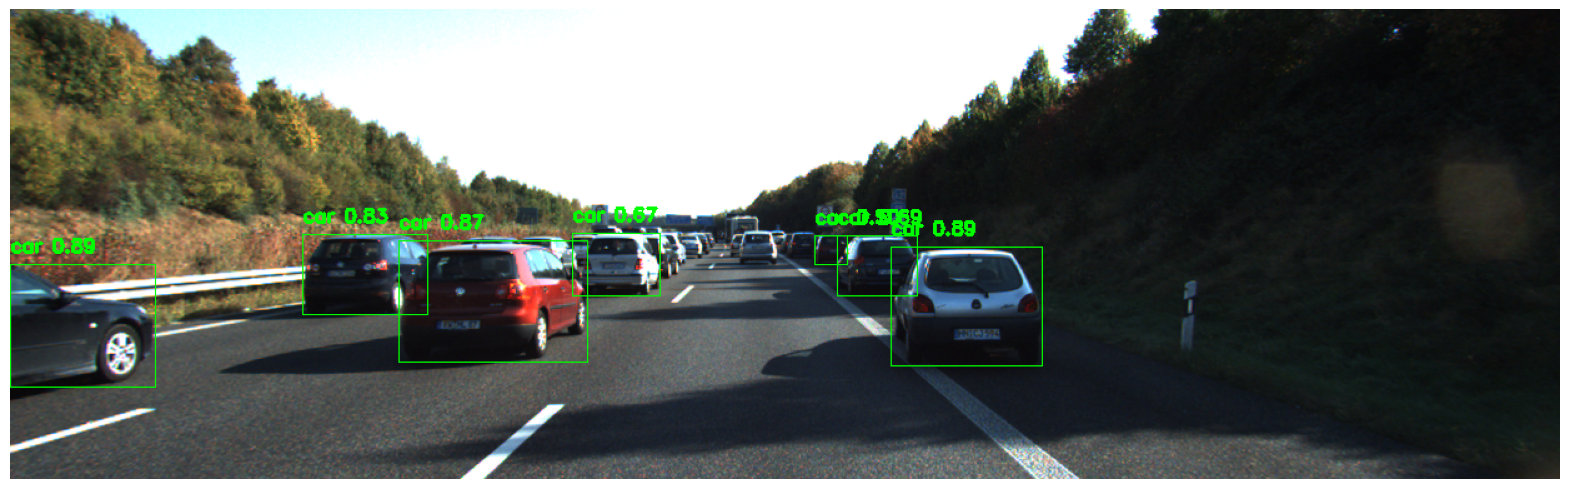

In [55]:
index = 10

left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
bin_path = bin_paths[index]
oxts_frame = get_oxts(oxts_paths[index])

# get detections and object centers in uvz
bboxes, velo_uvz = get_detection_coordinates(left_image, bin_path)

# get transformed coordinates of object centers
uvz = bboxes[:, -3:]

# transform to (u,v,z)
# velo_xyz = transform_uvz(uvz, T_cam2_velo) # we can also get LiDAR coordiantes
imu_xyz = transform_uvz(uvz, T_cam2_imu)

# get Lat/Lon on each detected object
lat0 = oxts_frame[0]
lon0 = oxts_frame[1]
alt0 = oxts_frame[2]
heading0 = oxts_frame[5]

lla = imu2geodetic(imu_xyz[:, 0], imu_xyz[:, 1], imu_xyz[:, 2], lat0, lon0, alt0, heading0)

In [56]:
velo_image = draw_velo_on_image(velo_uvz, np.zeros_like(left_image))

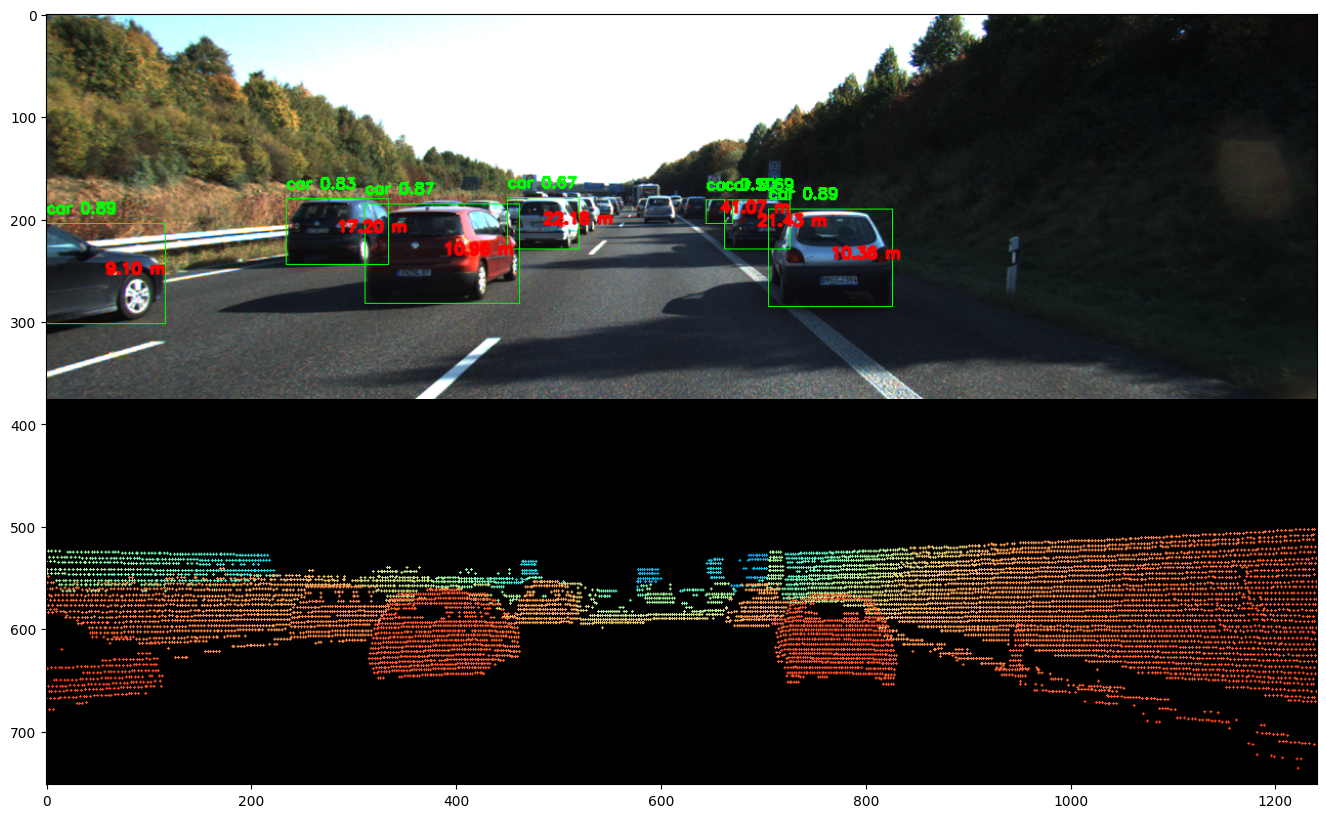

In [58]:
# pymap3d seems to mess with matplotlib in colab
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

# stack image with LiDAR point cloud
stacked = np.vstack((left_image, velo_image))

# display stacked iamge
plt.imshow(stacked)

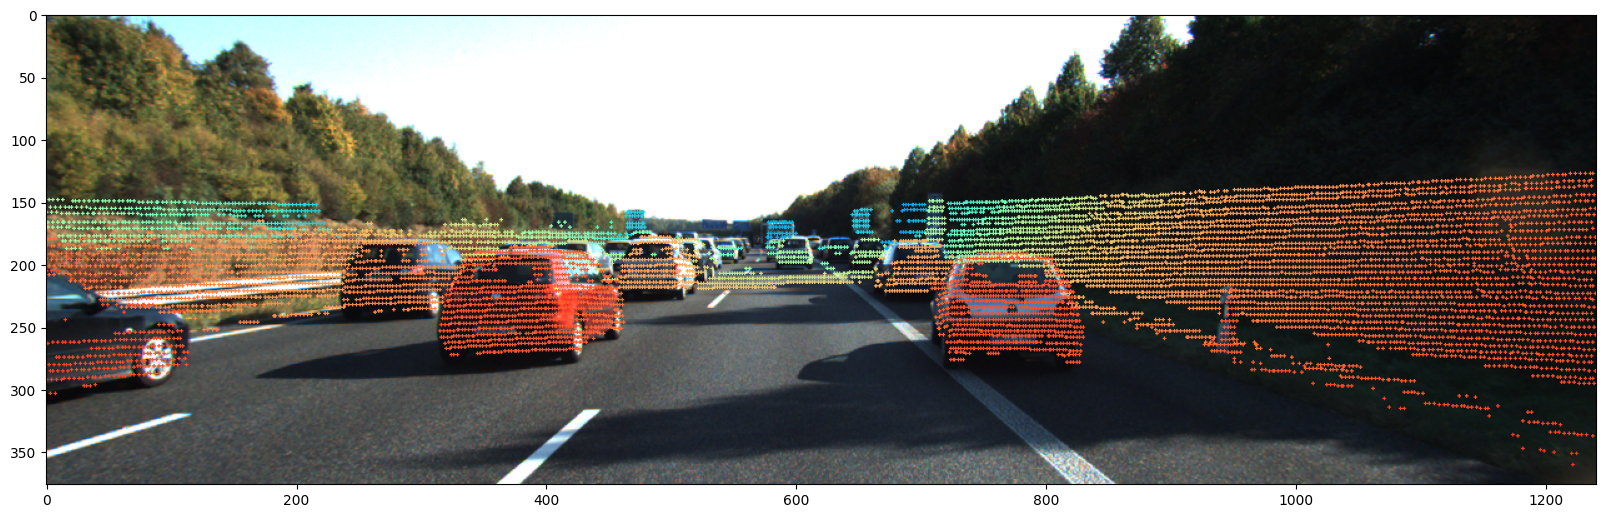

In [59]:
left_image_2 = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
velo_image_2 = draw_velo_on_image(velo_uvz, left_image_2)

plt.imshow(velo_image_2)

We can see that the errors betwee the theoretical IMU x values and the actual x values are fairly low. For the remaining IMU values we can wee that the y (horizontal) and z (vertical) have numbers that make sense based on the object locations on the image.

Now that we have locations for each object we can recontsruct the scene at each frame, using the LLA locations.

In [61]:
import folium

drive_map = folium.Map(
    location=(lat0, lon0), # starting location
    zoom_start=18
)

# add Lat/Lon points to map
folium.CircleMarker(location=(lat0, lon0),
                    radius=2,
                    weight=5,
                    color='red').add_to(drive_map);

In [62]:
# place the position of each detection on the map
for pos in lla:
    folium.CircleMarker(location=(pos[0], pos[1]),
                        radius=2,
                        weight=5,
                        color='green').add_to(drive_map);

# add Lat/Lon points to map
folium.CircleMarker(location=(lat0, lon0),
                    radius=2,
                    weight=5,
                    color='red').add_to(drive_map);

In [63]:
drive_map

Now we can use opencv2 to display the environment detected by the Camera and LiDAR. In this case we will draw a rectangle for every detected object, but you can use the detected MSCOCO class in bboxes and draw custom symbols for each different object. You could also cluster the data in LiDAR space and draw sybols based on the clustered data shape.

In [64]:
canvas_height = stacked.shape[0]
canvas_width = 500

# get consistent center for ego vehicle
ego_center = (250, int(canvas_height*0.95))

# get rectangle coordiantes for ego vehicle
ego_x1 = ego_center[0] - 5
ego_y1 = ego_center[1] - 10
ego_x2 = ego_center[0] + 5
ego_y2 = ego_center[1] + 10

In [65]:
def draw_scenario(canvas, imu_xyz, sf=12):
    # draw ego vehicle
    cv2.rectangle(canvas, (ego_x1, ego_y1), (ego_x2, ego_y2), (0, 255, 0), -1);

    # draw detected objects
    for val in imu_xyz:
        obj_center = (ego_center[0] - sf*int(np.round(val[1])),
                      ego_center[1] - sf*int(np.round(val[0])))
        # cv2.circle(canvas, obj_center, 5, (255, 0, 0), -1);

        # get object rectangle coordinates
        obj_x1 = obj_center[0] - 5
        obj_y1 = obj_center[1] - 10
        obj_x2 = obj_center[0] + 5
        obj_y2 = obj_center[1] + 10

        cv2.rectangle(canvas, (obj_x1, obj_y1), (obj_x2, obj_y2), (255, 0, 0), -1);

    return canvas

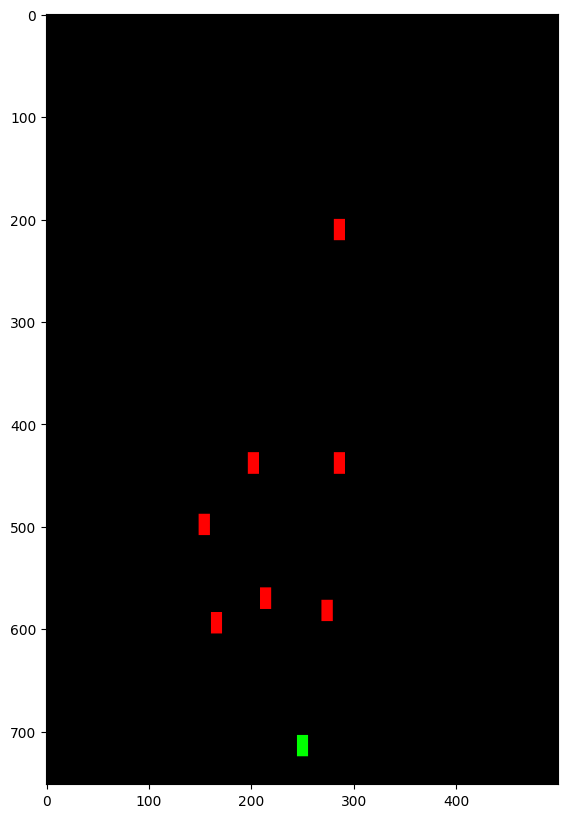

In [66]:
canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)
draw_scenario(canvas, imu_xyz, sf=12)
plt.imshow(canvas)

Now we stack all of the images together into a single frame!

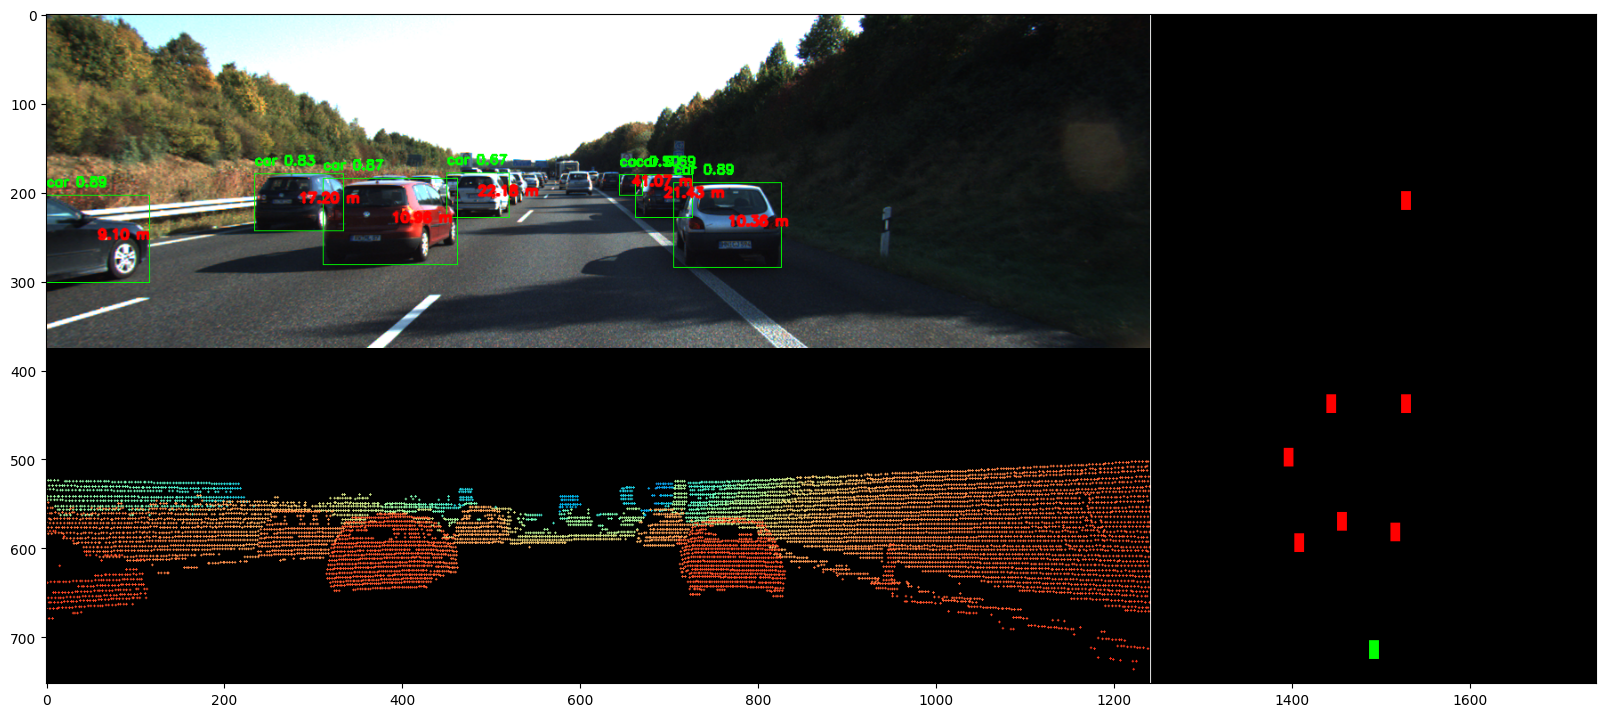

In [67]:
frame = np.hstack((stacked, 
                  255*np.ones((canvas_height, 1, 3), dtype=np.uint8),
                  canvas))

plt.imshow(frame);